# Importación de librerias

In [1]:
import cv2 # Tracker
import numpy as np #Operaciones matemáticas
import matplotlib.pyplot as plt # Gráficas
import pandas as pd # Base de datos
from scipy.signal import savgol_filter # Suavizar
from scipy.interpolate import splev, splrep # Interpolar con Spline

plt.rcParams['figure.figsize'] = [10, 6]

# Cargar el video

In [2]:
# Cargar videos y sus propiedades
cap = cv2.VideoCapture("Data/Video.mp4") # Se importa el video

NF = cap.get(cv2.CAP_PROP_FRAME_COUNT) # Número de Frames
FPS = cap.get(cv2.CAP_PROP_FPS) # Frame per seconds
time = NF/FPS # Duración vídeo
Altura = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Alto del vídeo
Ancho = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # Ancho del vídeo


# Primer Frame

In [3]:
#Extrae el 1er Frame y lo vuelve una imagen

ret, frame = cap.read() #Se obtiene la información de frames del video
cv2.imwrite("Data/frame1.jpg", frame) # Se guarda el primer frame

True

# Conversión px a cm

In [4]:
# Función para obtener coordendas a partir del click derecho

def mouse_callback(event, x, y, flags, params):

    if event == 2: # 2 indica click derecho
        global right_clicks
        right_clicks.append([x, y]) # Guarda las coordendas
        
        # Crear la vara de calibración con base en 2 puntos
        img_color = cv2.imread("Data/frame1.jpg")
        cv2.circle(img_color, (x,y), radius = 4, color = (0,0,255), thickness = -1)
        if len(right_clicks)> 1:
            cv2.line(img_color, tuple(right_clicks[0]),tuple(right_clicks[1]), color = (0, 0, 255), thickness = 2)
        cv2.imshow("image",img_color)

In [5]:
# Carga la imagen y obtiene las coordenadas

right_clicks = list() # Lista vacía para guardar los clicks

# Cargar frame inicial
img = cv2.imread("Data/frame1.jpg") 
cv2.imshow("image", img)

# Invocar mouse click events
cv2.setMouseCallback("image", mouse_callback)

cv2.waitKey(0)
cv2.destroyAllWindows()
print(right_clicks)

[[86, 342], [178, 342]]


In [6]:
# Conversión pixeles a medidas reales

dire = "X" #Dirección de referencia X o Y
real = 10 #Medida real
conv = 0 #Conversión pixeles a unidades

if dire == "X":
    conv = real/(abs(right_clicks[0][0]-right_clicks[1][0]))
else:
    conv = real/(abs(right_clicks[0][1]-right_clicks[1][1]))

# Función Bbox

In [7]:
# Función para actualizar el bbox en el vídeo
def drawBox(frame,bbox):
    # (x,y) Esquina superior izquierda del bbox
    # (w,h) Esquina inferior derecha del bbox
    x,y,w,h =  int(bbox[0]),int(bbox[1]),int(bbox[2]),int(bbox[3]) # Obtiene la información de cada bbox
    cv2.rectangle(frame,(x,y),((x+w),(y+h)),(255,0,255),3) # Crear bbox en cada frame
    return x,y,w,h

# Video Tracking 

In [8]:
cap = cv2.VideoCapture("Data/Video.mp4") # Se importa el video

tracker = cv2.TrackerCSRT_create() # Se inicializa la herramienta de tracker (pip install --user opencv-contrib-python)

ret, frame = cap.read() #Se obtiene la información de frames del video

bbox = cv2.selectROI("Frame",frame,False)
tracker.init(frame,bbox)

x_coord = []
y_coord = []

while(cap.isOpened()):
    
    ret, frame = cap.read() #Se obtiene la información de frames del video
       
    if ret == True:
        ret2,bbox = tracker.update(frame)
        if ret2 == True:
            x,y,w,h = drawBox(frame,bbox)
            x_coord.append(x*conv + w*conv/2)
            y_coord.append(Altura*conv-(y*conv + h*conv/2))
            cv2.putText(frame,"Tracking",(75,50),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)
        else:
            cv2.putText(frame,"Lost",(75,50),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)
            
        cv2.imshow('Frame',frame) #Muestra la ventana del vídeo    
        k = cv2.waitKey(33)
        if k == ord(" "): # Usar barra espaciadora para pausar o reproducir el video
                cv2.waitKey(-1)
        if k == ord("q"): #Usar q para cerrar la ventaa
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

# Análisis Cinemático

## Posición

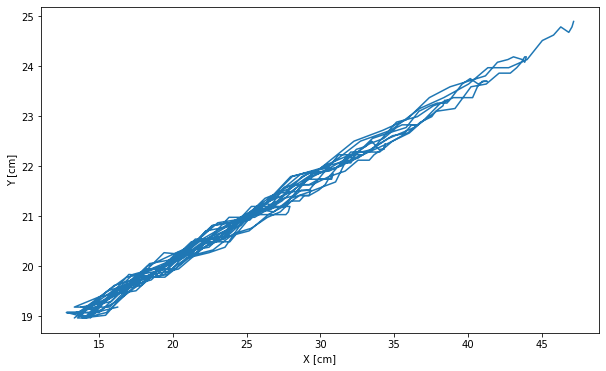

In [9]:
# Gráficar x vs y
plt.plot(x_coord, y_coord)
plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")
plt.show()

In [10]:
# Lista de tiempo
list_time =  np.arange(0, time + time / (len(x_coord)),time/(len(x_coord)-1)).tolist()

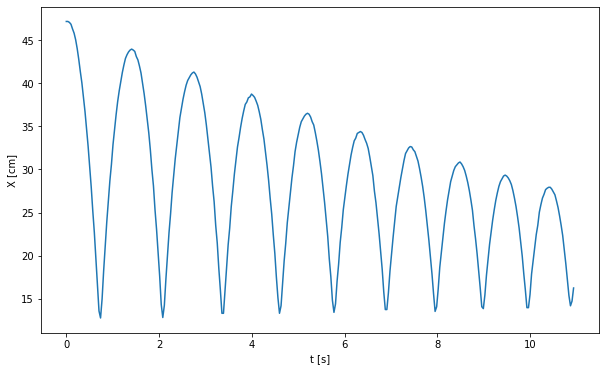

In [11]:
# Gráfica de t vs. x

plt.plot(list_time, x_coord)
plt.xlabel("t [s]")
plt.ylabel("X [cm]")
plt.show()

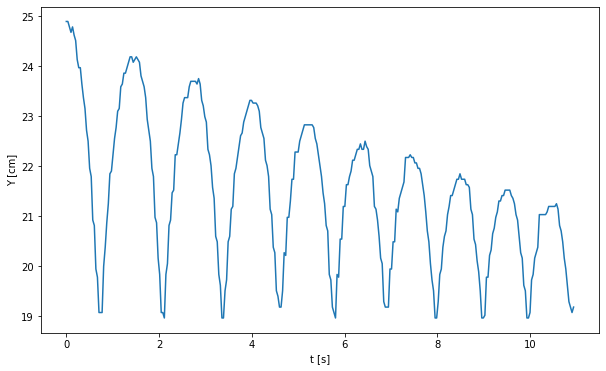

In [12]:
# Gráfica de t vs. y

plt.plot(list_time,y_coord)
plt.xlabel("t [s]")
plt.ylabel("Y [cm]")
plt.show()

## Datos Tracker

Datos cinemáticos obtenidos con el software [Tracker](https://physlets.org/tracker/) para hacer una comparativa

In [13]:
# Cargar datos de excel

DT = pd.read_excel("Data/Tracker_Data.xlsx")
DT.head()

,t,x,y,vx,vy,ax,ay
0,0.033333,53.772711,28.876048,NaN,NaN,NaN,NaN
1,0.066667,53.364569,28.978083,-12.858265,0.059521,NaN,NaN
2,0.100000,52.915493,28.880016,-17.080179,-3.468888,-133.746887,-54.426204
3,0.133333,52.225890,28.746824,-22.464122,-3.378773,-152.600205,-20.724071
4,0.166667,51.417885,28.654764,-26.869875,-4.369302,-130.955882,-29.215211


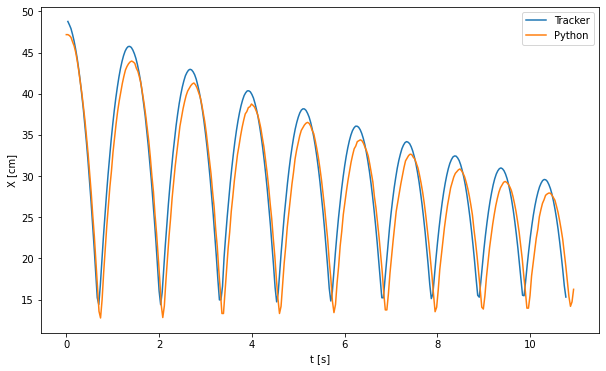

In [14]:
# Gráfica t vs x

plt.plot(DT["t"], DT["x"] - 5, label = "Tracker")
plt.plot(list_time, x_coord, label = "Python")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("X [cm]")
plt.show()

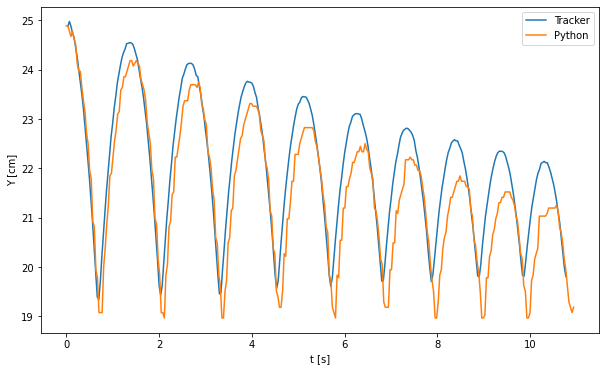

In [15]:
# Gráfica t vs y

plt.plot(DT["t"], DT["y"] - 4, label = "Tracker")
plt.plot(list_time, y_coord, label = "Python")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("Y [cm]")
plt.show()

## Velocidad

Inicialmente la velocidad se calcula con base en la relación entre el cambio de posición y tiempo

$$v_{x} = \frac{\Delta x}{\Delta t} \approx \frac{dx}{dt}$$ 

$$v_{y} = \frac{\Delta y}{\Delta t} \approx \frac{dy}{dt}$$ 

In [16]:
## Velocidades
vxd = []
vyd = []
for i in range(len(list_time)-1):
    vxd.append((x_coord[i+1]-x_coord[i])/(list_time[i+1]-list_time[i]))
    vyd.append((y_coord[i+1]-y_coord[i])/(list_time[i+1]-list_time[i]))

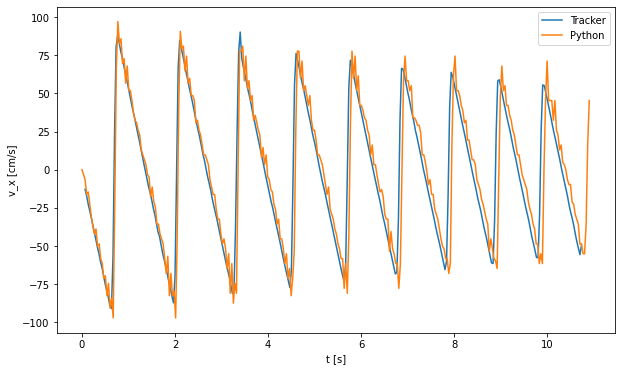

In [17]:
# Gráfica velocidad vx

plt.plot(DT["t"], DT["vx"], label = "Tracker")
plt.plot(list_time[:-1], vxd, label = "Python")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_x [cm/s]")
plt.show()


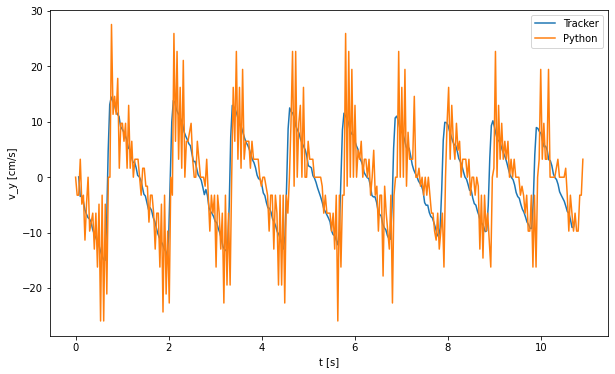

In [18]:
# Gráfica velocidad vy

plt.plot(DT["t"], DT["vy"], label = "Tracker")
plt.plot(list_time[:-1], vyd, label = "Python")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_y [cm/s]")
plt.show()

### Suavizar datos de posición

<!-- Debido al ruido que presentan los datos, se aplica un proceo de suavización de datos empleando un [Filtro de Savitzky–Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) -->

In [19]:
## Suavizar

xs = savgol_filter(x_coord, 11, 3) # window size 51, polynomial order 3
ys = savgol_filter(y_coord, 17, 3) # window size 51, polynomial order 3

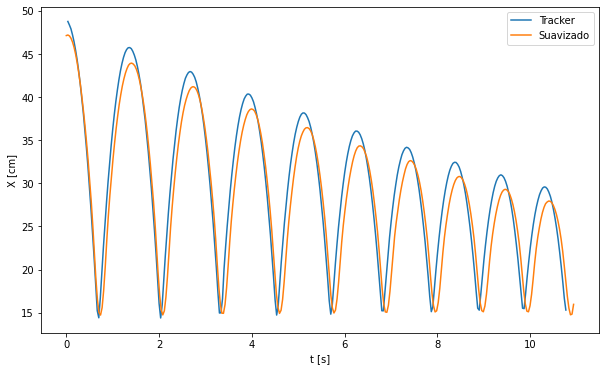

In [20]:
# Gráfica suavizada de x vs t

plt.plot(DT["t"], DT["x"] - 5, label = "Tracker")
plt.plot(list_time, xs, label = "Suavizado")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("X [cm]")
plt.show()


Podemos evlauar varios parémtros del filtro usando un slider del paquete de [widgets](https://ipywidgets.readthedocs.io/en/stable/) de Python

In [21]:
# Slider x

import ipywidgets as wg
from IPython.display import display

def my_plotx(a,b):
    a = int(a)
    b = int(b)
    xs = savgol_filter(x_coord, a, b) # window size 51, polynomial order 3
    plt.figure(figsize = (10,4))
    plt.plot(DT["t"], DT["x"] - 5, label = "Tracker")
    plt.plot(list_time, xs, label = "Suavizado")
    plt.legend()

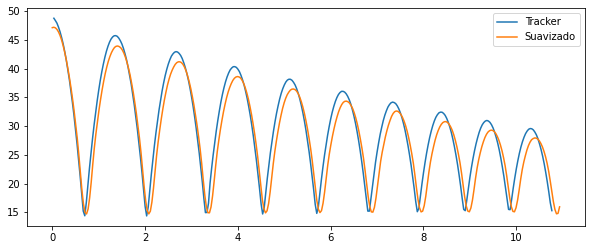

In [22]:
my_plotx(11,3)

In [23]:
a_slide = wg.FloatSlider(value = 11, min = 5, max = 101, step = 2)
b_slide = wg.FloatSlider(value = 3, min = 0, max = 10, step = 1)
wg.interact(my_plotx, a = a_slide, b = b_slide)

interactive(children=(FloatSlider(value=11.0, description='a', max=101.0, min=5.0, step=2.0), FloatSlider(valu…

<function __main__.my_plotx(a, b)>

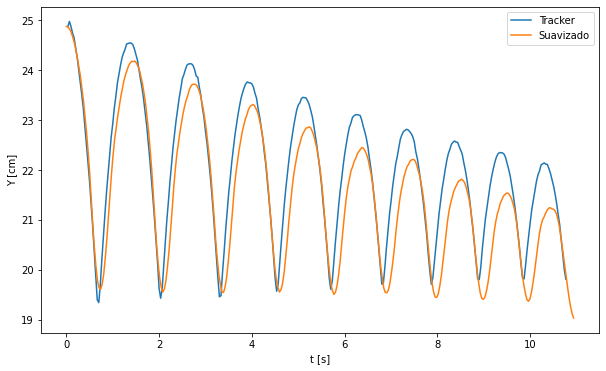

In [24]:
# Gráfica suavizada de y vs t

plt.plot(DT["t"], DT["y"] - 4, label = "Tracker")
plt.plot(list_time, ys, label = "Suavizado")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("Y [cm]")
plt.show()

In [25]:
# Slider y

def my_ploty(a,b):
    a = int(a)
    b = int(b)
    ys = savgol_filter(y_coord, a, b) # window size 51, polynomial order 3
    plt.figure(figsize = (10,4))
    plt.plot(DT["t"], DT["y"] - 4, label = "Tracker")
    plt.plot(list_time, ys, label = "Suavizado")
    plt.legend()
    

In [26]:
a_slide = wg.FloatSlider(value = 17, min = 5, max = 51, step = 2)
b_slide = wg.FloatSlider(value = 3, min = 0, max = 10, step = 1)
wg.interact(my_ploty, a = a_slide, b = b_slide)

interactive(children=(FloatSlider(value=17.0, description='a', max=51.0, min=5.0, step=2.0), FloatSlider(value…

<function __main__.my_ploty(a, b)>

In [27]:
## Velocidades

vxd = []
vyd = []
for i in range(len(list_time)-1):
    vxd.append((xs[i+1]-xs[i])/(list_time[i+1]-list_time[i]))
    vyd.append((ys[i+1]-ys[i])/(list_time[i+1]-list_time[i]))

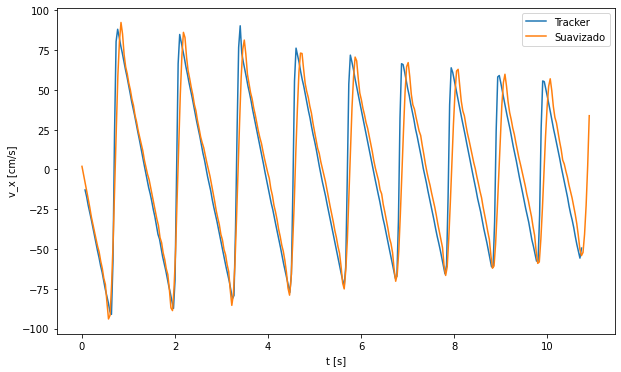

In [28]:
# Velocidad en X

plt.plot(DT["t"], DT["vx"], label = "Tracker")
plt.plot(list_time[:-1], vxd, label = "Suavizado")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_x [cm/s]")
plt.show()

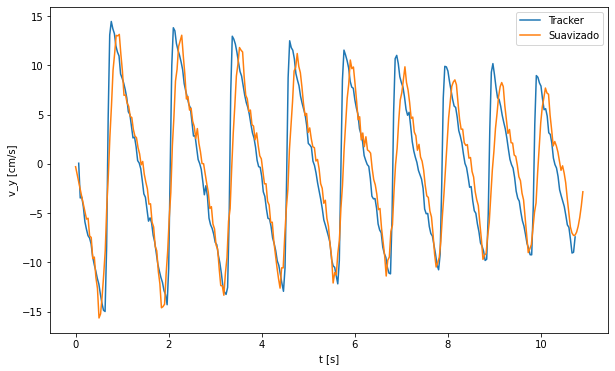

In [29]:
# Velocidad en Y

plt.plot(DT["t"],DT["vy"], label ="Tracker")
plt.plot(list_time[:-1],vyd, label = "Suavizado")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_y [cm/s]")
plt.show()

### Interpolación tipo Spline



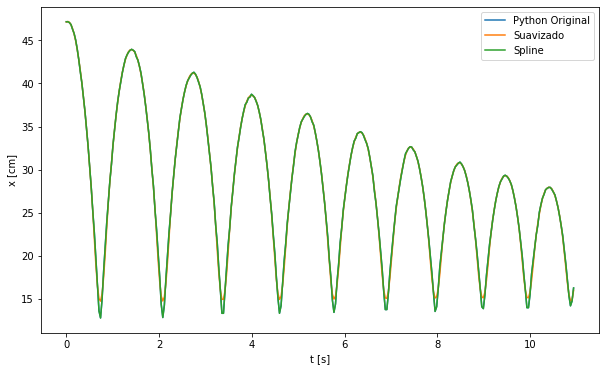

In [30]:
## Interpolación con Spline X
spl1 = splrep(list_time,x_coord)
new_x = splev(list_time,spl1)

plt.plot(list_time,x_coord, label = "Python Original")
plt.plot(list_time,xs,label = "Suavizado")
plt.plot(list_time,new_x, label = "Spline")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("x [cm]")
plt.show()

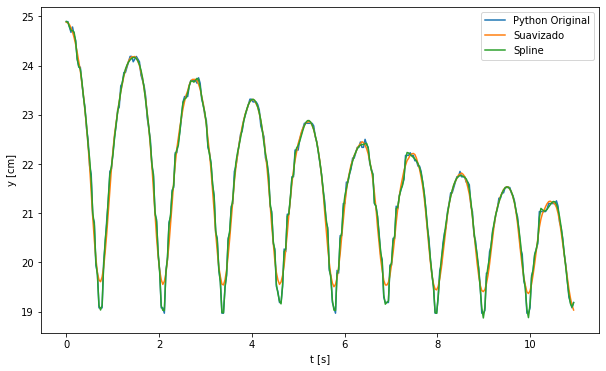

In [31]:
## Interpolación con Spline Y
spl2 = splrep(list_time,y_coord, s = 1)
new_y =splev(list_time,spl2)

plt.plot(list_time,y_coord, label = "Python Original")
plt.plot(list_time,ys, label = "Suavizado")
plt.plot(list_time,new_y, label = "Spline")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("y [cm]")
plt.show()

In [32]:
# Widget

def spline_1(a):
    spl2 = splrep(list_time,y_coord,s = a)
    new_y =splev(list_time,spl2)
    plt.figure(figsize = (10,4))
    plt.plot(list_time,y_coord,label="Python")
    plt.plot(list_time,ys,label="Suavizado")
    plt.plot(list_time,new_y,label="Spline")
    plt.legend()

In [33]:
a_slider = wg.FloatSlider(value = 1, min = 1, max = 100, step = 1)
wg.interact(spline_1, a = a_slider)

interactive(children=(FloatSlider(value=1.0, description='a', min=1.0, step=1.0), Output()), _dom_classes=('wi…

<function __main__.spline_1(a)>

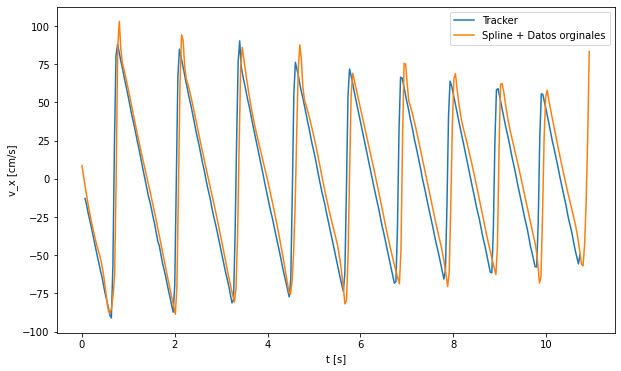

In [34]:
# Velocidad en X Spline + Datos orginales

spl1 = splrep(list_time,x_coord, s = 10)
new_vx =splev(list_time,spl1,der=1)
plt.plot(DT["t"],DT["vx"],label = "Tracker")
plt.plot(list_time,new_vx,label = "Spline + Datos orginales")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_x [cm/s]")
plt.show()

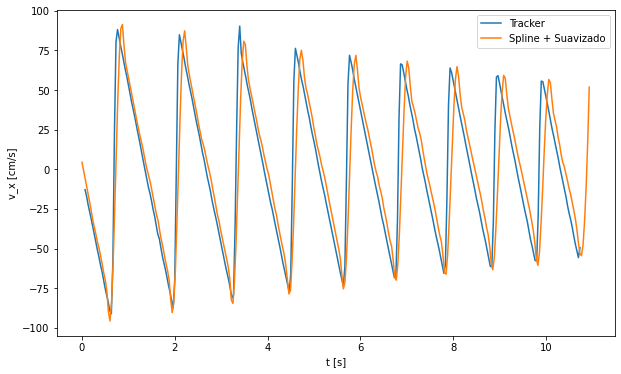

In [35]:
# Velocidad en X Spline + Datos Suavizados

spl1 = splrep(list_time,xs)
new_vx =splev(list_time,spl1,der = 1)
plt.plot(DT["t"], DT["vx"], label = "Tracker")
plt.plot(list_time, new_vx, label = "Spline + Suavizado")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_x [cm/s]")
plt.show()

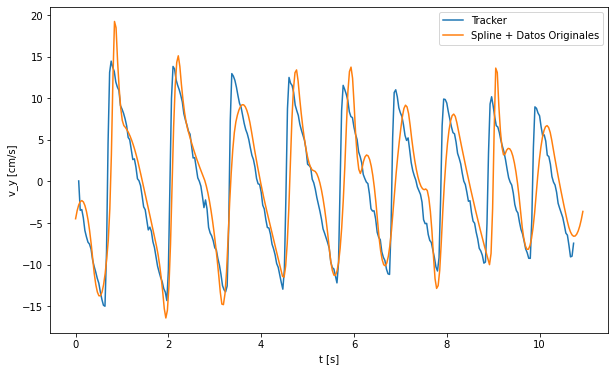

In [36]:
# Velocidad en Y Spline + Datos Originales 

spl2 = splrep(list_time,y_coord,s = 10)
new_vy =splev(list_time,spl2,der = 1)
plt.plot(DT["t"], DT["vy"], label = "Tracker")
plt.plot(list_time,new_vy, label="Spline + Datos Originales")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_y [cm/s]")
plt.show()

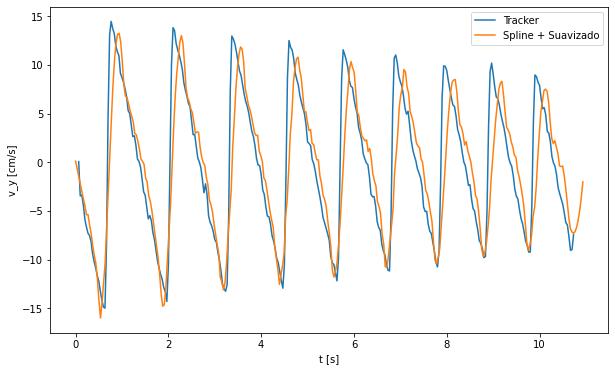

In [37]:
# Velocidad en Y Spline + Datos Suavizados

spl2 = splrep(list_time,ys)
new_vy =splev(list_time,spl2,der = 1)

plt.plot(DT["t"], DT["vy"], label = "Tracker")
plt.plot(list_time, new_vy, label = "Spline + Suavizado")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_y [cm/s]")
plt.show()

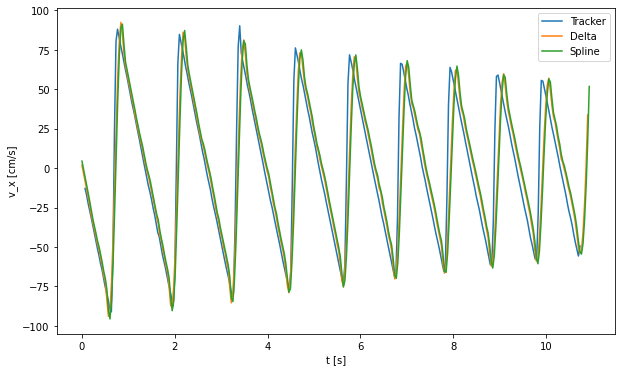

In [38]:
# Gráficas finales de velocidad x

plt.plot(DT["t"],DT["vx"],label = "Tracker")
plt.plot(list_time[:-1],vxd,label = "Delta")
plt.plot(list_time,new_vx,label = "Spline")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_x [cm/s]")
plt.show()

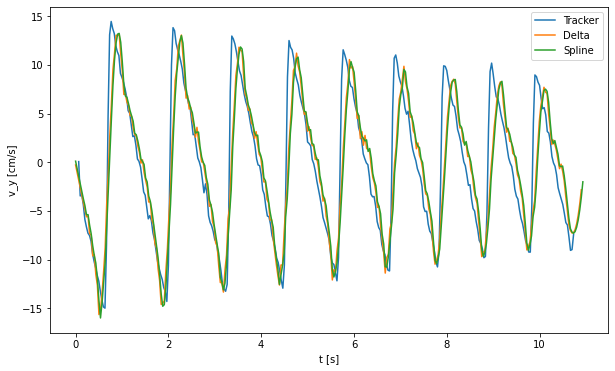

In [39]:
# Gráficas finales de velocidad y

plt.plot(DT["t"],DT["vy"], label = "Tracker")
plt.plot(list_time[:-1], vyd,label = "Delta")
plt.plot(list_time,new_vy, label = "Spline")
plt.legend()
plt.xlabel("t [s]")
plt.ylabel("v_y [cm/s]")
plt.show()

## Aceleración

La aceleración se calcula con base en la relación entre el cambio de velocidad y tiempo

$$a_{x} = \frac{\Delta v_x}{\Delta t} \approx \frac{dv_x}{dt}$$ 

$$a_{y} = \frac{\Delta v_y}{\Delta t} \approx \frac{dv_y}{dt}$$ 

In [40]:
## Aceleración

ax = []
ay = []
for i in range(len(list_time)-2):
    ax.append((vxd[i+1]-vxd[i])/(list_time[i+1]-list_time[i]))
    ay.append((vyd[i+1]-vyd[i])/(list_time[i+1]-list_time[i]))

In [41]:
# Aceleración con Spline

new_ax =splev(list_time, spl1, der = 2)
new_ay =splev(list_time, spl2, der = 2)

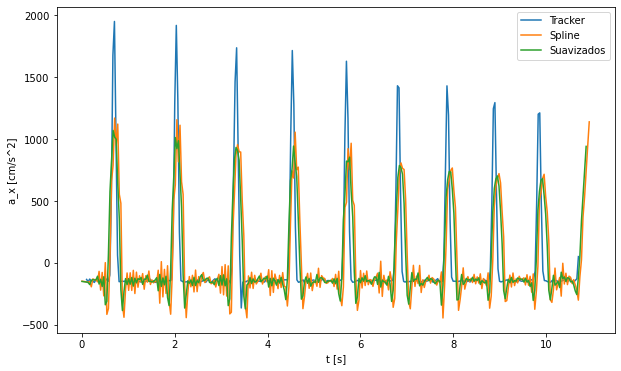

In [42]:
# Gráfica aceleración ax

plt.plot(DT["t"], DT["ax"], label = "Tracker")
plt.plot(list_time, new_ax, label = "Spline")
plt.plot(list_time[:-2], ax, label = "Suavizados")

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("a_x [cm/s^2]")
plt.show()

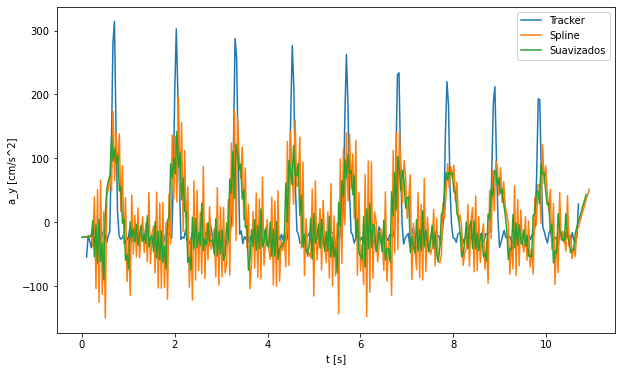

In [43]:
# Gráfica velocidad ay

plt.plot(DT["t"], DT["ay"], label = "Tracker")
plt.plot(list_time, new_ay, label = "Spline")
plt.plot(list_time[:-2], ay, label = "Suavizados")

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("a_y [cm/s^2]")
plt.show()